In [1]:
using GPFlux
using LinearAlgebra
using Flux
using Zygote
using Random; Random.seed!(4);
using Plots
using Statistics
using DelimitedFiles
using Optim
using Test

┌ Info: Precompiling GPFlux [4d4e40ad-7e7d-4024-a1b1-ebf43adef3b8]
└ @ Base loading.jl:1273
┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/hongbinren/.julia/packages/CUDAdrv/aBgcd/src/CUDAdrv.jl:69


In [2]:
# read CO2 data
data = readdlm("data/CO2_data.csv", ',')
year = data[:,1]; co2 = data[:,2];
# Split the data into training and testing data
oxtrain = year[year.<2004]; oytrain = co2[year.<2004];
oxtest = year[year.>=2004]; oytest = co2[year.>=2004];

# preprocessing
xtrain_mean = mean(oxtrain)
xtrain_std = std(oxtrain)
ytrain_mean = mean(oytrain)
ytrain_std = std(oytrain)

xtrain = @. (oxtrain-xtrain_mean)/xtrain_std
xtest = @. (oxtest-xtrain_mean)/xtrain_std
ytrain = @. (oytrain-ytrain_mean)/ytrain_std

Year = reshape(year, 1, length(year));
Xtrain = reshape(xtrain, 1, length(xtrain));
Xtest = reshape(xtest, 1, length(xtest));

In [18]:
# kernel parameter initialization
function median_distance_local(x)
    n = length(x)
    dist = []
    for i in 1:n
        for j in i:n
            push!(dist, abs(x[j]-x[i]))
        end
    end
    median(dist)
end

l = median_distance_local(xtrain)

1.013116421583688

In [21]:
# mean function
zero_mean = ConstantMean()

# kernel
iso_se_kernel = IsoGaussKernel([log(l)], [0.0])
iso_lin_kernel = IsoLinearKernel([0.0])
iso_rq_kernel = IsoRQKernel([log(l)], [log(0.2)], [0.0])
iso_per_kernel = IsoPeriodKernel([log(l)], [log(l)], [0.0])
lin = Linear(4, 2) |> f64

player = Primitive(iso_se_kernel, iso_lin_kernel, iso_rq_kernel, iso_per_kernel)
nkn_kernel = NeuralKernelNetwork(player, lin, allProduct)

NeuralKernelNetwork(Primitive(IsoGaussKernel(ll=0.013031146188736197, lσ=0.0), IsoLinearKernel(lσv=0.0), IsoRQKernel(ll=0.013031146188736197, lα=-1.6094379124341003, lσ=0.0, IsoPeriodKernel(lp=0.013031146188736197, ll=0.013031146188736197, lσ=0.0)), Linear(4,2), allProduct)

)

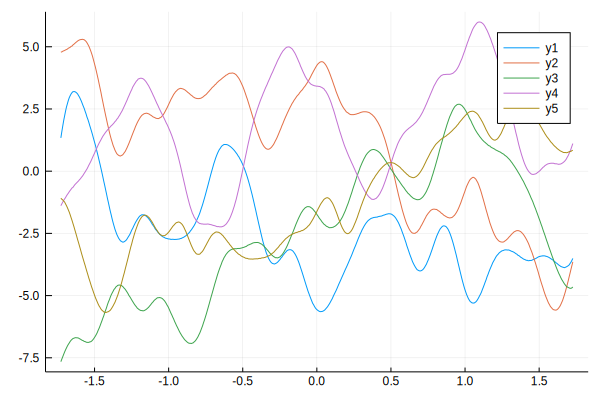

In [22]:
# sample from prior
gp_prior = GaussProcess(zero_mean, nkn_kernel, [-Inf])
dist_gp_prior = MvNormal(gp_prior, Xtrain)
samples = rand(dist_gp_prior, 5)
plot(xtrain, samples)

In [23]:
# build gp for training
lnoise = [0.5*log(0.1)]
gp = GaussProcess(zero_mean, nkn_kernel, lnoise)
ps = params(gp)
negloglik(gp, Xtrain, ytrain)

-14.990637924124371

In [ ]:
# minimize negative loglik

using Flux.Optimise: update!

optimizer = ADAM(0.001)
loss = []
for i in 1:5000
    ll = negloglik(gp, Xtrain, ytrain)
    push!(loss, ll)
    if i==1 || i%500 == 0
        @info "step=$i, loss=$ll"
    end
    gs = gradient(()->negloglik(gp, Xtrain, ytrain), ps)
    for p in ps
        update!(optimizer, p, gs[p])
    end
end

┌ Info: step=1, loss=-14.990637924124371
└ @ Main In[24]:11
┌ Info: step=500, loss=-257.20113270706065
└ @ Main In[24]:11
┌ Info: step=1000, loss=-366.35091908198115
└ @ Main In[24]:11
┌ Info: step=1500, loss=-385.40583270532466
└ @ Main In[24]:11
┌ Info: step=2000, loss=-387.61701784778893
└ @ Main In[24]:11
┌ Info: step=2500, loss=-388.2660186987398
└ @ Main In[24]:11


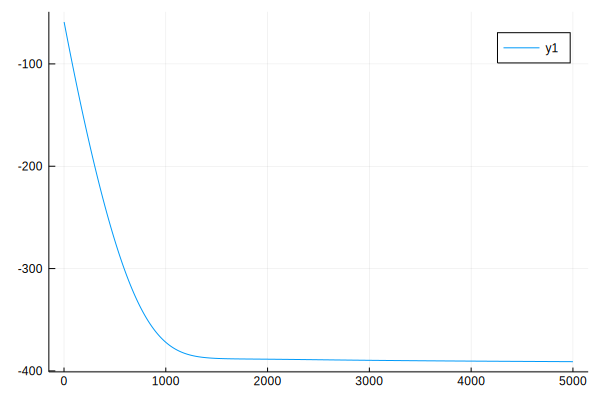

In [16]:
plot(loss)

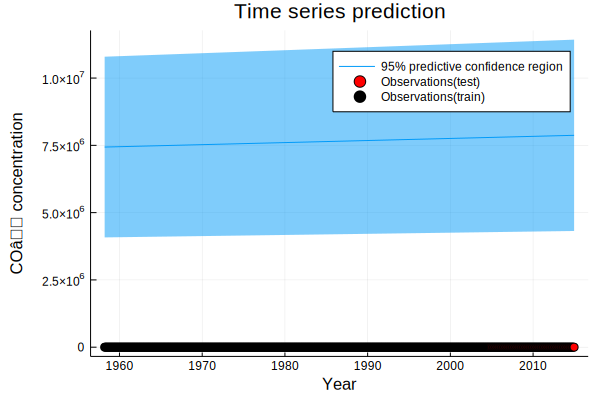

In [17]:
pred_y, pred_σ2 = predict(gp, Year, Xtrain, ytrain)
pred_σ = sqrt.(pred_σ2)
pred_oy = @. pred_y*ytrain_std+ytrain_mean
pred_oσ = @. pred_σ*ytrain_std

plot(year, pred_oy, ribbon=pred_oσ, title="Time series prediction",label="95% predictive confidence region")
scatter!(oxtest, oytest, label="Observations(test)", color=:red)
scatter!(oxtrain, oytrain, label="Observations(train)", color=:black)
plot!(xaxis=("Year"), yaxis=("CO₂ concentration"))